# Diageo Iowa Sales Performance Evaluation: Data Ingestion & Cleaning for Diageo's Iowa Sales

**Objective:** The goal of this notebook is to perform the initial data ingestion and cleaning process. I take the raw, multi-file Iowa Liquor Sales dataset, combine it, clean it, and prepare a final, reliable dataset ready for analysis.

**Key Steps:**
1.  Load and combine all raw CSV files
2.  Data Quality Assessment & Cleaning 
   - 2.1 Data Types: Validate and correct variable data types
   - 2.2 Missing Values: Detect nulls and apply appropriate imputation or removal
   - 2.3 Duplicates: Identify and eliminate duplicate records
   - 2.4 Value Consistency & Outlier Detection : Standardize categorical values & Detect and review outliers in quantitative variables
   - 2.5 Add New Columns: Create additional variables from existing ones to bring more meaning to the data (e.g. extracting month from date, calculating revenue, grouping categories)

   A detailed **issue log** documenting all detected issues and how they were handled is available [here](../Data/Raw_data/Issue%20log.csv).

3.  Save the final, clean dataset to a database for the next stage of analysis.

# 1. Load and combine all raw CSV files

In [2]:
# === IMPORT LIBRARIES ===
import pandas as pd
import glob
import os

# === LOAD & COMBINE DATA ===
csv_folder = 'C:/Users/vothk/Portfolio/Diageo-Iowa-B2B-Sales-Performance-Forecasting-Dashboard-for-2025/Data/Raw_data'
csv_files = glob.glob(os.path.join(csv_folder, '*.csv'))
df_list = [pd.read_csv(file) for file in csv_files]
df_raw = pd.concat(df_list, ignore_index=True)

# === CHECK DATA SHAPE ===
print(df_raw.shape)
pd.set_option('display.max_columns', None)
df_raw.head()

(6444061, 24)


,Invoice/Item Number,Date,Store Number,Store Name,Address,City,Zip Code,Store Location,County Number,County,Category,Category Name,Vendor Number,Vendor Name,Item Number,Item Description,Pack,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons)
0,INV-54554500001,01/02/2023,5245,BEST TRIP,"1516, SE 1ST ST",DES MOINES,50315.0,POINT (-93.61379 41.57608),NaN,POLK,1022200,100% AGAVE TEQUILA,260,DIAGEO AMERICAS,89177,CASAMIGOS REPOSADO,6,750,29.99,44.99,3,134.97,2.25,0.59
1,INV-54554700023,01/02/2023,6303,WORLD LIQUOR & TOBACCO + VAPORS / DES MOINES,3200 SOUTHEAST 14TH STREET,DES MOINES,50320.0,POINT (-93.59738 41.55503),NaN,POLK,1022100,MIXTO TEQUILA,395,PROXIMO,89193,JOSE CUERVO ESPECIAL REPOSADO,48,200,3.63,5.45,48,261.60,9.60,2.53
2,INV-54554700003,01/02/2023,6303,WORLD LIQUOR & TOBACCO + VAPORS / DES MOINES,3200 SOUTHEAST 14TH STREET,DES MOINES,50320.0,POINT (-93.59738 41.55503),NaN,POLK,1012200,SCOTCH WHISKIES,260,DIAGEO AMERICAS,4626,BUCHANAN DELUXE 12YR,12,750,20.99,31.49,12,377.88,9.00,2.37
3,INV-54554100007,01/02/2023,2190,"CENTRAL CITY LIQUOR, INC.",1460 2ND AVE,DES MOINES,50314.0,POINT (-93.61979 41.60558),NaN,POLK,1032100,IMPORTED VODKAS,978,W J DEUTSCH & SONS LTD,34598,LUKSUSOWA VODKA,6,1750,14.84,22.26,6,130.50,10.50,2.77
4,INV-54554300002,01/02/2023,2699,HY-VEE C-STORE #2 - ANKENY,1710 SW ORALABOR ROAD,ANKENY,50023.0,POINT (-93.62362 41.70324),NaN,POLK,1031100,AMERICAN VODKAS,301,FIFTH GENERATION INC,38176,TITOS HANDMADE VODKA,12,750,10.00,15.00,24,360.00,18.00,4.75


After combining all the data, I began assessing the dataset by examining:
    - Meaning of each row
    - Variables meaning
    - The logical relation between variables
    - Critical variables for our project's business goals
Based on this initial review, each record in the dataset represents an individual sales transaction. The most important columns include sales values, quantity sold, and transaction date. Additionally, the dataset contains supplementary information about retailer locations.

A detailed **Data Dictionary**, outlining the variables, their meanings, and their relevance to the project objectives, can be found [here](../Data/Raw_data/Data_Dictionary.csv).

# 2. Data Quality Assessment & Cleaning
Now that I have a single DataFrame, I can perform a thorough data quality check — including data types, missing values, duplicates, value consistency, outlier detection, and logical validity.

## 2.1 Data Types: Validate and correct variable data types

In [3]:
# Inspect Data Types
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6444061 entries, 0 to 6444060
Data columns (total 24 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Invoice/Item Number    object 
 1   Date                   object 
 2   Store Number           int64  
 3   Store Name             object 
 4   Address                object 
 5   City                   object 
 6   Zip Code               float64
 7   Store Location         object 
 8   County Number          float64
 9   County                 object 
 10  Category               int64  
 11  Category Name          object 
 12  Vendor Number          int64  
 13  Vendor Name            object 
 14  Item Number            int64  
 15  Item Description       object 
 16  Pack                   int64  
 17  Bottle Volume (ml)     int64  
 18  State Bottle Cost      float64
 19  State Bottle Retail    float64
 20  Bottles Sold           int64  
 21  Sale (Dollars)         float64
 22  Volume Sold (Liter

> There are two variables with incorrect data types:
> - Date: Currently assigned as `object` → should be converted to `datetime` for proper time-based operations and filtering.
> - Zip Code: Currently assigned as `float` → should be converted to `object`, since zip codes often start with a leading zero (e.g., "02108"), and treating them as text ensures that the leading zeros are preserved.

In [4]:
# Change Data Types
# Change var "Date" Data Types
df_raw["Date"] = pd.to_datetime(df_raw["Date"])
# Change var "Zip Code " Data Types
df_raw["Zip Code"] = df_raw["Zip Code"].astype(object)
# Recheck data type
df_raw.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6444061 entries, 0 to 6444060
Data columns (total 24 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   Invoice/Item Number    object        
 1   Date                   datetime64[ns]
 2   Store Number           int64         
 3   Store Name             object        
 4   Address                object        
 5   City                   object        
 6   Zip Code               object        
 7   Store Location         object        
 8   County Number          float64       
 9   County                 object        
 10  Category               int64         
 11  Category Name          object        
 12  Vendor Number          int64         
 13  Vendor Name            object        
 14  Item Number            int64         
 15  Item Description       object        
 16  Pack                   int64         
 17  Bottle Volume (ml)     int64         
 18  State Bottle Cost     

## 2.2 Missing Values: Detect nulls and apply appropriate imputation or removal

In [5]:
# Inspect Null Values
df_raw.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6444061 entries, 0 to 6444060
Data columns (total 24 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   Invoice/Item Number    6444061 non-null  object        
 1   Date                   6444061 non-null  datetime64[ns]
 2   Store Number           6444061 non-null  int64         
 3   Store Name             6444061 non-null  object        
 4   Address                6441976 non-null  object        
 5   City                   6441976 non-null  object        
 6   Zip Code               6441976 non-null  object        
 7   Store Location         6413769 non-null  object        
 8   County Number          0 non-null        float64       
 9   County                 6441976 non-null  object        
 10  Category               6444061 non-null  int64         
 11  Category Name          6444061 non-null  object        
 12  Vendor Number          64440

In [6]:

# Inspect Null values and Null rate
# Define new function to check null values and null rate
def calc_null_rate(df):
 newdf = df.isnull().sum().to_frame('null_count')
 newdf[['null_rate']] = (newdf[['null_count']] / len(df)) * 100
 return newdf.sort_values(by=['null_rate'], ascending=False)
# Check null rate
calc_null_rate(df_raw)

,null_count,null_rate
County Number,6444061,100.000000
Store Location,30292,0.470076
Address,2085,0.032355
Zip Code,2085,0.032355
County,2085,0.032355
City,2085,0.032355
Store Name,0,0.000000
Store Number,0,0.000000
Invoice/Item Number,0,0.000000
Date,0,0.000000


> There are 6 variables containing null values:
>
> - County Number: This variable consists entirely of nulls. Since location-related information is already available in other fields such as County, Address, and City, and this variable is not critical for our analysis, it will be dropped.
>
> - Store Location, Address, Zip Code, County, and City: These variables each have a null rate of less than 1%. Given their low impact and potential usefulness, they will be retained as-is.


In [7]:
# Drop var "County Number"
df_raw = df_raw.drop(columns=["County Number"])
# Recheck data type
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6444061 entries, 0 to 6444060
Data columns (total 23 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   Invoice/Item Number    object        
 1   Date                   datetime64[ns]
 2   Store Number           int64         
 3   Store Name             object        
 4   Address                object        
 5   City                   object        
 6   Zip Code               object        
 7   Store Location         object        
 8   County                 object        
 9   Category               int64         
 10  Category Name          object        
 11  Vendor Number          int64         
 12  Vendor Name            object        
 13  Item Number            int64         
 14  Item Description       object        
 15  Pack                   int64         
 16  Bottle Volume (ml)     int64         
 17  State Bottle Cost      float64       
 18  State Bottle Retail   

## 2.3 Duplicates: Identify and eliminate duplicate records

In [8]:
# Check duplicates by row/transaction
df_raw.duplicated().sum()

np.int64(0)

> The result shows there is no duplicate transaction.

Next, I’ll check for duplicate values in the key variable Invoice/Item Number, which should be unique since each number represents a single transaction.


In [9]:
df_raw["Invoice/Item Number"].nunique(), df_raw.shape[0]

(6444061, 6444061)

> There is no duplicate values in "Invoice/item Number" variable.

## 2.4 Value Consistency & Outlier Detection : Standardize categorical values & Detect and review outliers in quantitative variables

I'll divide the checking of value consistency into 2 types:
- 2.4.1 Qualitative columns
- 2.4.2 Quantitative columns

### 2.4.1 Qualitative columns

#### 2.4.1.1 Standardize format

First, I’ll:
- Strip whitespace
- Convert all uppercase values in the dataset to lowercase to make the data easier to read and work with.

In [10]:
# Define quali vars
cat_cols = ["Store Name", "Vendor Name", "City", "County", "Category Name", "Item Description"]
# Strip whitespace and convert uppercase values to lowercase
for col in cat_cols:
    df_raw[col] = df_raw[col].astype(str).str.strip().str.lower().str.title()

#### 2.4.1.2 Check similar values

Next, I'll check similar values within each qualitative variable. Starting by define the function to check similarity.

In [11]:
#Define function to check similar values
from fuzzywuzzy import fuzz
from itertools import combinations

def suggest_similar_values(df_raw, column, threshold=95):
    # Get list of unique values
    values = df_raw[column].dropna().unique()

    # Compare each pair of values
    similar_pairs = []
    for a, b in combinations(values, 2): # --> Compare a pair of value in "values"
        # Calculate fuzzy similarity score between a and b:
            # Use token sort ratio: sort words in the string then compare
            # Return score 0 → 100 (the higher the more similar).
        score = fuzz.token_sort_ratio(a, b) 
        if score >= threshold:
            similar_pairs.append((a, b, score))
    
    # Create DataFrame from similar pairs
    similar_pairs_df = pd.DataFrame(similar_pairs, columns=["Value A", "Value B", "Similarity"])
    return similar_pairs_df.sort_values(by="Similarity", ascending=False)

Next, I’ll examine similar value pairs within each variable.  
Pairs with 100% similarity will be auto-corrected, while those from 95 - 99% similarity will be reviewed manually based on context.

##### Store Name variable

Review Store Name similarity

In [12]:
similar_store_names = suggest_similar_values(df_raw, "Store Name", threshold=95)
similar_store_names

,Value A,Value B,Similarity
283,Hy-Vee Fast & Fresh/Altoona,Hy-Vee Fast & Fresh / Altoona,100
299,Lefty'S Convenience Store Inc.,Lefty'S Convenience Store Inc,100
324,Quik Stop / Burlington,Quik Stop / Burlington,100
274,Prime Mart - Cedar Falls,Prime Mart / Cedar Falls,100
384,Wych Dr Distilling Co / Et,Wych Dr Distilling Co / (Et),100
...,...,...,...
353,Casey'S General Store #2630 / Cedar Falls,Casey'S General Store #2865 / Cedar Falls,95
354,Casey'S General Store #2458 / Mason City,Casey'S General Store #2437 / Mason City,95
362,Casey'S General Store #2763 / Cedar Rapids,Casey'S General Store # 2780/Cedar Rapids,95
1,Casey'S General Store #2773 / Cedar Rapids,Casey'S General Store # 2792/Cedar Rapids,95


> For the "Store Name" variable, there are two main types of similarity:
> 
> - Pairs with 100% similarity, which are caused by differences in name formatting (e.g., punctuation or spacing).  
> - Pairs with less than 100% similarity, which represent different branches of the same store chain. These are valid entries and will not be modified.

I will now proceed to standardize the store names with 100% similarity.


In [13]:
# Merge map from 100% similar pairs
merge_map = {}
for _, row in similar_store_names.iterrows():
    a, b, score = row["Value A"], row["Value B"], row["Similarity"]
    if score == 100:
        shorter = min(a, b, key=len)
        merge_map[a] = shorter
        merge_map[b] = shorter

# Replace within the variable
df_raw["Store Name"] = df_raw["Store Name"].replace(merge_map)


Check data after replacing

In [14]:
similar_store_names = suggest_similar_values(df_raw, "Store Name", threshold=95)
similar_store_names

,Value A,Value B,Similarity
32,Smokin' Joe'S #11 Tobacco And Liquor Outlet,Smokin' Joe'S #1 Tobacco And Liquor Outlet,99
45,Smokin' Joe'S #16 Tobacco And Liquor Outlet,Smokin' Joe'S #1 Tobacco And Liquor Outlet,99
335,Casey'S General Store #45 / Des Moines,Casey'S General Store #4 / Des Moines,99
26,Smokin' Joe'S #7 Tobacco And Liquor Outlet,Smokin' Joe'S #17 Tobacco And Liquor Outlet,99
97,Smokin' Joe'S #1 Tobacco And Liquor Outlet,Smokin' Joe'S #17 Tobacco And Liquor Outlet,99
...,...,...,...
344,Casey'S General Store #2772 / Cedar Rapids,Casey'S General Store #2768 / Cedar Rapids,95
343,Casey'S General Store #2772 / Cedar Rapids,Casey'S General Store #2763 / Cedar Rapids,95
342,Casey'S General Store #3050 / Council Bluffs,Casey'S General Store #3201 / Council Bluffs,95
341,Casey'S General Store #3610 / Cedar Falls,Casey'S General Store #2630 / Cedar Falls,95


> The `Store Name` variable is now cleaned and ready.

Next, I’ll continue with the remaining variables.


##### Vendor Name variable

In [15]:
similar_vendor_names = suggest_similar_values(df_raw, "Vendor Name", threshold=90)
similar_vendor_names

,Value A,Value B,Similarity


> No similar value pairs were found in the "Vendor Name" variable.

##### City variable

In [16]:
similar_city = suggest_similar_values(df_raw, "City", threshold=90)
similar_city

,Value A,Value B,Similarity
0,Clearlake,Clear Lake,95


In [17]:
df_raw["City"] = df_raw["City"].replace({"Clearlake": "Clear Lake"})

In [18]:
similar_city = suggest_similar_values(df_raw, "City", threshold=90)
similar_city

,Value A,Value B,Similarity


##### County variable

In [19]:
similar_County = suggest_similar_values(df_raw, "County", threshold=90)
similar_County

,Value A,Value B,Similarity


> No similar value pairs were found in the "County" variable.

##### Category Name variable

In [20]:
similar_Category_Name = suggest_similar_values(df_raw, "Category Name", threshold=90)
similar_Category_Name

,Value A,Value B,Similarity


> No similar value pairs were found in the "Category Name" variable.

Now all the qualitative variables are cleaned and clear to use.

### 2.4.1 Quantitative columns

In this section, I assess the **consistency and logic** of quantitative variables to ensure that the numerical data is clean, meaningful, and ready for analysis.

I focus on identifying potential data issues such as:
- **Zero or negative values**: Flag illogical entries that may indicate input errors.
- **Invalid values**: Detect unexpected values (e.g., bottle volume = 0 or 99999) that are outside a reasonable range.
- **Constant or low-variance columns**: Spot variables with little to no variation, which may offer limited analytical value.
- **Uncommon or suspicious values**: Highlight unusual figures for further review.

After validating consistency, I also proceed to **identify outliers** — not necessarily to remove them, but to **understand their context**.

This step ensures numerical data quality before moving on to modeling or advanced analysis.


Quantitative Columns to Check

Among all quantitative columns in the dataset, I chose to focus on the following key columns for consistency checks, as they are directly relevant to business performance metrics:

| Column                  | Reason                                                                 |
|-------------------------|------------------------------------------------------------------------|
| `State Bottle Cost`     | Unit cost – helps identify data entry errors (e.g. zero or negative values) |
| `State Bottle Retail`   | Unit retail price – can be compared against cost to validate pricing logic |
| `Sale (Dollars)`        | Total revenue – critical for all sales-related analyses                  |
| `Bottles Sold`          | Volume driver – useful for identifying anomalous quantity values         |
| `Volume Sold (Liters)`  | Useful for unit conversion checks and logical consistency                |
| `Volume Sold (Gallons)` | Can be compared to liters (1 gallon = 3.78541 liters) to ensure accuracy |

Other numeric columns like IDs or structural codes (e.g., `Vendor Number`, `Item Number`, `Pack`) are not checked here, as they serve primarily as identifiers rather than metrics.

To begin, I’ll examine the summary statistics of these columns to understand their distribution and central tendencies.


In [21]:
numeric_cols_to_check = ["State Bottle Cost", "State Bottle Retail", "Sale (Dollars)", "Bottles Sold", "Volume Sold (Liters)", "Volume Sold (Gallons)"]
display(df_raw[numeric_cols_to_check].describe().T)

,count,mean,std,min,25%,50%,75%,max
State Bottle Cost,6444061.0,13.470403,19.124955,0.52,6.50,9.99,16.00,24989.02
State Bottle Retail,6444061.0,20.206033,28.686326,0.00,9.75,14.99,24.00,37483.53
Sale (Dollars),6444061.0,170.122722,615.969414,-8355.84,49.68,92.98,171.00,260832.00
Bottles Sold,6444061.0,12.010467,34.966286,-768.00,3.00,6.00,12.00,13200.00
Volume Sold (Liters),6444061.0,8.964761,40.443260,-1344.00,1.50,4.50,9.60,13200.00
Volume Sold (Gallons),6444061.0,2.362530,10.684173,-355.04,0.39,1.18,2.53,3487.07


Several key data quality issues have been identified:

- **Potential Outliers**: The maximum values for sales and cost-related variables are significantly higher than the mean. This suggests the presence of potential outliers, possibly due to large bulk purchases.

- **Zero-Priced Items**: The minimum value for State Bottle Retail is $0.00. A zero price typically does not represent a valid sale and may indicate free samples or data errors.

- **Negative Sales & Volume**: Both Sale (Dollars) and Bottles Sold contain negative values. These likely indicate product returns or data entry errors rather than actual sales. These records will be examined further in the following steps.

Next, I’ll drill down into each variable to investigate these values in more detail.


First, I’ll check the distribution these variables and look for outliers using box plots

C:\Users\vothk\AppData\Local\Temp\ipykernel_9148\2971446890.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, vert=False, labels=cols_to_visualize)


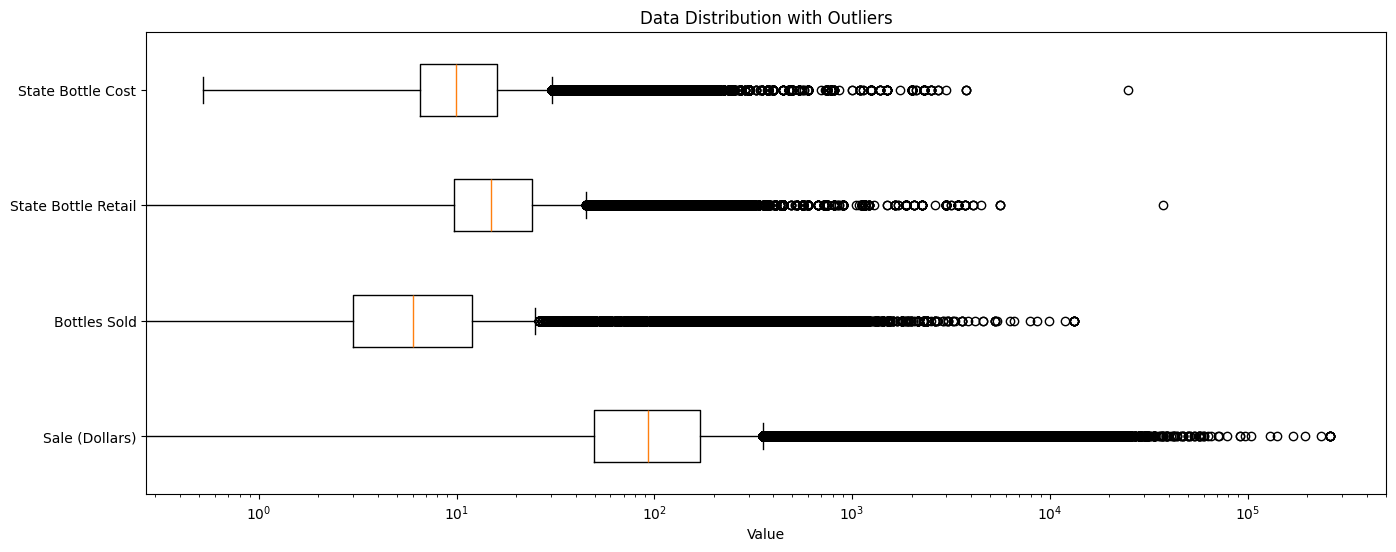

In [22]:
import matplotlib.pyplot as plt

#Define variables & dataframe to check
cols_to_visualize = ["Sale (Dollars)",  "Bottles Sold", "State Bottle Retail", "State Bottle Cost"] 
data = [df_raw[col] for col in cols_to_visualize]

# Create a figure contain charts
plt.figure(figsize=(16, 6)) 

# Draw box plot
plt.boxplot(data, vert=False, labels=cols_to_visualize)

# Add title and axis label
plt.title('Data Distribution with Outliers')
plt.xlabel('Value')

# Use log scale to improve visibility of skewed distributions
plt.xscale('log')

plt.show()

> - `State Bottle Cost` and `State Bottle Retail` contain several high outliers, but these seem consistent — likely due to premium products where high cost leads to high retail prices, rather than data entry errors.  
> - `Bottles Sold` and `Sale (Dollars)` are also heavily skewed, possibly due to bulk purchases.

Next, I’ll investigate outlier values in each variable individually to assess their validity and business logic.

#### State Bottle Cost & State Bottle Retail

Both `State Bottle Cost` and `State Bottle Retail` exhibit similar distributions and are closely related. The cost reflects the price at which the Iowa state government purchases alcohol from vendors, while the retail price is what the state sells to retailers.

Since the markup between cost and retail is generally consistent across products and transactions. Therefore, I will analyze the maximum values and their impact for **both variables together** in this step to assess if any high values are unusual or require further investigation.


In [23]:
# Define outlier threshold
State_Bottle_Cost_Q1 = df_raw["State Bottle Cost"].quantile(0.25)
State_Bottle_Cost_Q3 = df_raw["State Bottle Cost"].quantile(0.75)
State_Bottle_Cost_IQR = State_Bottle_Cost_Q3 - State_Bottle_Cost_Q1
State_Bottle_Cost_Lower_Bound = State_Bottle_Cost_Q1 - 1.5 * State_Bottle_Cost_IQR
State_Bottle_Cost_Upper_Bound = State_Bottle_Cost_Q3 + 1.5 * State_Bottle_Cost_IQR
df_large_bottle_cost = df_raw[(df_raw["State Bottle Cost"] < State_Bottle_Cost_Lower_Bound) | (df_raw["State Bottle Cost"] > State_Bottle_Cost_Upper_Bound)]

# Display outlier transactions
cols_to_display = ["Store Name", "City", "Vendor Name", "Category Name", "Item Description", "State Bottle Cost", "State Bottle Retail", "Bottles Sold", "Sale (Dollars)", "Volume Sold (Liters)"]
display(df_large_bottle_cost[cols_to_display])


,Store Name,City,Vendor Name,Category Name,Item Description,State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters)
10,"Central City Liquor, Inc.",Des Moines,Best Case Wines Llc,Imported Brandies,Sooh Millet Armagnac Xo,38.00,57.00,2,114.00,1.50
23,Casey'S General Store #2532 / Eldora,Eldora,Sazerac Company Inc,Whiskey Liqueur,Fireball Cinnamon Whiskey Party Bucket,51.60,77.40,2,154.80,0.10
34,"Central City Liquor, Inc.",Des Moines,Constellation Brands Inc,100% Agave Tequila,Casa Noble Anejo,32.68,49.02,2,98.04,1.50
41,"Central City Liquor, Inc.",Des Moines,Diageo Americas,100% Agave Tequila,Don Julio Blanco,30.99,46.49,6,278.94,4.50
48,Central City 2,Des Moines,Diageo Americas,Scotch Whiskies,Johnnie Walker Blue,130.00,195.00,1,195.00,0.75
...,...,...,...,...,...,...,...,...,...,...
6443992,Virulas General Store / Sioux City,Sioux City,Sazerac Company Inc,American Schnapps,99 Bananas Mini,52.40,78.60,1,78.60,0.05
6444002,Hy-Vee Wine And Spirits / Bettendorf,Bettendorf,Park Street Imports,100% Agave Tequila,Cazcanes Blanco Tequila No 9,49.00,73.50,6,441.00,4.50
6444023,Hy-Vee Food Store / Sheldon,Sheldon,Diageo Americas,Canadian Whiskies,Crown Royal,33.99,50.99,6,305.94,10.50
6444025,Hy-Vee Wine And Spirits / Bettendorf,Bettendorf,Brown Forman Corp.,Tennessee Whiskies,Jack Daniels Old #7 Black Label,33.28,49.92,6,299.52,10.50


> Most of the liquor types falling into the outlier range are premium products, which explains the high input costs — this suggests that the data is **genuine** rather than due to input errors.
> 
> Since the state’s purchase prices (`State Bottle Cost`) are high, the corresponding retail prices (`State Bottle Retail`) are also elevated. This explains the **right-skewed distribution** observed in both variables.

While most outliers can be logically explained, I will further investigate the **two most extreme data points** with the highest retail prices to ensure there are no underlying issues.

In [24]:
### Validating Extreme Outliers
display(df_large_bottle_cost[cols_to_display].sort_values(by="State Bottle Cost", ascending = False).head (2))

,Store Name,City,Vendor Name,Category Name,Item Description,State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters)
2534356,Three Doors Down Liquor,Whittemore,Pernod Ricard Usa,Single Malt Scotch,Ha Midleton Silent Distillery Chapter 4,24989.02,37483.53,1,37483.53,0.70
4004426,Kum & Go #1113 / Ames,Ames,Sazerac Company Inc,Blended Whiskies,Ha Weller Millennium,3750.00,5625.00,1,5625.00,0.75


> - The highest-cost transaction refers to Midleton Silent Distillery Chapter 4, one of the rarest and most expensive Irish whiskeys in the world. This exceptionally high cost is justified and accurately recorded.
> 
> - The second-highest transaction is for a premium blended whiskey, also rare and costly. The value is consistent with its market price and is valid.
> 
> Based on this review, the outlier values are confirmed to be accurate. No corrections or removals are needed.


Although most outliers were confirmed to be valid, I also found some transactions with a `State Bottle Retail` value of 0. I will now investigate these cases further.

In [25]:
cols_to_display_retail = ["Store Name", "Vendor Name", "Category Name", "Item Description", "State Bottle Cost", "State Bottle Retail", "Bottles Sold", "Sale (Dollars)"]
display(df_raw[cols_to_display_retail][df_raw["State Bottle Retail"]==0])

,Store Name,Vendor Name,Category Name,Item Description,State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars)
5811664,Hy-Vee Drugstore #5 / Cedar Rapids,Pernod Ricard Usa,Cocktails/Rtd,Malibu Strawberry Daiquiri Ready To Serve Cock...,7.5,0.0,12,135.00
5836575,Sherpa Liquor & Tobacco Outlet 1 / Burlington,Pernod Ricard Usa,Cocktails/Rtd,Malibu Pineapple Bay Breeze Ready To Serve Coc...,7.5,0.0,12,135.00
5838285,Sherpa Liquor & Tobacco Outlet 1 / Burlington,Pernod Ricard Usa,Cocktails/Rtd,Malibu Strawberry Daiquiri Ready To Serve Cock...,7.5,0.0,12,135.00
5838848,Brew Oil #26 / Pocahontas,Pernod Ricard Usa,Cocktails/Rtd,Malibu Pineapple Bay Breeze Ready To Serve Coc...,7.5,0.0,2,22.50
5842787,Hy-Vee Food Store / Coralville,Pernod Ricard Usa,Cocktails/Rtd,Malibu Pineapple Bay Breeze Ready To Serve Coc...,7.5,0.0,12,135.00
5844627,Hy-Vee Wine & Spirits / Muscatine,Pernod Ricard Usa,Cocktails/Rtd,Malibu Rum Punch Ready To Serve Cocktail,7.5,0.0,3,33.75
5845163,Beecher Liquor / Dubuque,Pernod Ricard Usa,Cocktails/Rtd,Malibu Strawberry Daiquiri Ready To Serve Cock...,7.5,0.0,4,45.00
5848679,Beecher Liquor / Dubuque,Pernod Ricard Usa,Cocktails/Rtd,Malibu Pineapple Bay Breeze Ready To Serve Coc...,7.5,0.0,2,22.50
5855872,Sunshine Foods / Hawarden,Pernod Ricard Usa,Cocktails/Rtd,Malibu Strawberry Daiquiri Ready To Serve Cock...,7.5,0.0,12,135.00
5859591,Hy-Vee Food Store #1 (1449) / Newton,Pernod Ricard Usa,Cocktails/Rtd,Malibu Strawberry Daiquiri Ready To Serve Cock...,7.5,0.0,12,135.00


These records contain values for `Bottles Sold` and `Sale (Dollars)` but have missing or zero values for `State Bottle Retail`, which suggests a possible data entry error. 

For the affected records, I will calculate and fill in the missing `State Bottle Retail` values using the formula:  
`State Bottle Retail = Sale (Dollars) / Bottles Sold`


In [26]:
# Filter transactions with 0 State Retail value
mask_zero_retail = df_raw["State Bottle Retail"] == 0

# Fill in those transactions by formula: State Bottle Retail = Sale (Dollars)/Bottles Sold
df_raw.loc[mask_zero_retail, "State Bottle Retail"] = (
    df_raw.loc[mask_zero_retail, "Sale (Dollars)"] /
    df_raw.loc[mask_zero_retail, "Bottles Sold"]
)

display(df_raw[cols_to_display_retail][df_raw["State Bottle Retail"]==0])

,Store Name,Vendor Name,Category Name,Item Description,State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars)


With this, the `State Bottle Retail` variable is now cleaned and ready for the next steps.

#### Bottles Sold

For Bottles Sold, I’ll review the top 10 transactions with the highest `Bottles Sold` to understand their influence on the data.


In [27]:
# Display the top 10 transactions with the highest number of bottles sold
cols_to_display = ["Invoice/Item Number", "Date","Store Name", "City", "Address", "Vendor Name", "Category Name", "Item Description", "State Bottle Retail", "Bottles Sold", "Sale (Dollars)", "Volume Sold (Liters)"]
display(df_raw[cols_to_display].sort_values(by="Bottles Sold", ascending = False).head(10))

,Invoice/Item Number,Date,Store Name,City,Address,Vendor Name,Category Name,Item Description,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters)
5939429,INV-81760800001,2025-04-21,Hy-Vee #3 / Bdi / Des Moines,Des Moines,3221 SE 14TH ST,Fifth Generation Inc,American Vodkas,Titos Handmade Vodka,19.76,13200,260832.0,13200.0
4035825,INV-72306000001,2024-07-18,Hy-Vee #3 / Bdi / Des Moines,Des Moines,3221 SE 14TH ST,Fifth Generation Inc,American Vodkas,Titos Handmade Vodka,19.76,13200,260832.0,13200.0
4719325,INV-75673900001,2024-10-24,Hy-Vee #3 / Bdi / Des Moines,Des Moines,3221 SE 14TH ST,Fifth Generation Inc,American Vodkas,Titos Handmade Vodka,19.76,13200,260832.0,13200.0
5392080,INV-79038800001,2025-01-27,Hy-Vee #3 / Bdi / Des Moines,Des Moines,3221 SE 14TH ST,Fifth Generation Inc,American Vodkas,Titos Handmade Vodka,19.76,13200,260832.0,13200.0
2156359,INV-63744400001,2023-10-30,Hy-Vee #3 / Bdi / Des Moines,Des Moines,3221 SE 14TH ST,Fifth Generation Inc,American Vodkas,Titos Handmade Vodka,19.76,13200,260832.0,13200.0
3452043,INV-69661600001,2024-04-29,Hy-Vee #3 / Bdi / Des Moines,Des Moines,3221 SE 14TH ST,Fifth Generation Inc,American Vodkas,Titos Handmade Vodka,19.76,13200,260832.0,13200.0
2739499,INV-66284100050,2024-01-15,Hy-Vee #3 / Bdi / Des Moines,Des Moines,3221 SE 14TH ST,Fifth Generation Inc,American Vodkas,Titos Handmade Vodka,19.76,13200,260832.0,13200.0
782568,INV-57786400063,2023-04-24,Hy-Vee #3 / Bdi / Des Moines,Des Moines,3221 SE 14TH ST,Fifth Generation Inc,American Vodkas,Titos Handmade Vodka,19.76,11880,234748.8,11880.0
194741,INV-55381600120,2023-01-30,Hy-Vee #3 / Bdi / Des Moines,Des Moines,3221 SE 14TH ST,Fifth Generation Inc,American Vodkas,Titos Handmade Vodka,19.76,9900,195624.0,9900.0
1460310,INV-60606600056,2023-07-24,Hy-Vee #3 / Bdi / Des Moines,Des Moines,3221 SE 14TH ST,Fifth Generation Inc,American Vodkas,Titos Handmade Vodka,19.76,8580,169540.8,8580.0


> The largest transactions were bulk purchases of "Titos Handmade Vodka" made by the store "Hy-Vee #3 / Bdi / Des Moines". These values are valid and accurately recorded.

However, as mentioned earlier, the Bottles Sold column contains negative values, which are unusual for a sales dataset. I will now investigate these records in detail.

In [28]:
# Display transactions that have negative bottles sold
cols_to_display = ["Invoice/Item Number", "Store Name", "City", "Vendor Name", "Category Name", "Item Description", "State Bottle Retail", "Bottles Sold", "Sale (Dollars)", "Volume Sold (Liters)"]
display(df_raw[cols_to_display][df_raw["Bottles Sold"]<=0])

,Invoice/Item Number,Store Name,City,Vendor Name,Category Name,Item Description,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters)
10874,RINV-04441100143,Hy-Vee Food Store #2 / State Ankeny,Ankeny,Diageo Americas,Cream Liqueurs,Baileys Original Irish Cream,24.74,-24,-593.76,-18.00
10875,RINV-04443700069,Madella Wine And Spirits / Bettendorf,Bettendorf,Jim Beam Brands,American Schnapps,Dekuyper Luscious Peachtree,11.81,-12,-141.72,-12.00
10876,RINV-04441200020,Mount Pleasant Food & Liquor / Mt Pleasant,Mt Pleasant,Diageo Americas,Spiced Rum,Captain Morgan Original Spiced Mini,7.20,-12,-86.40,-0.60
10877,RINV-04441400046,Top Shelf Liquor / Iowa City,Iowa City,Constellation Brands Inc,Temporary & Specialty Packages,High West Limited Supply Rendezvous Rye,60.00,-6,-360.00,-4.50
10878,RINV-04443600063,Madella Wine And Spirits / Bettendorf,Bettendorf,Pernod Ricard Usa,Irish Whiskies,Jameson Black Barrel,36.38,-12,-436.56,-9.00
...,...,...,...,...,...,...,...,...,...,...
6443297,RINV-05815500089,Johncy'S Liquor Store,North Liberty,Dv Spirits Llc,Cocktails/Rtd,Dulce Vida Paloma Rtd,10.50,-12,-126.00,-12.00
6443575,RINV-05816500009,Le Claire Grocery Store / Le Claire,Le Claire,Brown Forman Corp.,Tennessee Whiskies,Jack Daniels Tennessee Honey,23.87,-1,-23.87,-0.75
6443625,RINV-05815900028,Fareway Stores #167/Johnston,Johnston,Jim Beam Brands,Straight Bourbon Whiskies,Jim Beam,17.25,-12,-207.00,-9.00
6443696,RINV-05816400161,Lake Liquors Wine And Spirits / Clear Lake,Clear Lake,Campari America,Mezcal,Montelobos Espadin Mezcal,30.00,-1,-30.00,-0.75


> The transactions with negative Bottles Sold values represent product returns. In Iowa’s system, the state collects payment first, and the return is processed later — indicated by Invoice/Item Number starting with "RINV" (Return Invoice).

> Therefore, these entries are valid and do not require cleaning.

#### Sale

Similar to Bottles Sold, I will now examine the top 10 transactions with the highest Sale values to assess their impact on the data.

In [29]:
# Display top 10 highest sale transactions
cols_to_display_sale = ["Invoice/Item Number","Store Name", "Vendor Name", "Category Name", "Item Description", "Bottles Sold", "Sale (Dollars)", "Volume Sold (Liters)"]
display(df_raw[cols_to_display_sale].sort_values(by="Sale (Dollars)", ascending = False).head(10))

,Invoice/Item Number,Store Name,Vendor Name,Category Name,Item Description,Bottles Sold,Sale (Dollars),Volume Sold (Liters)
2156359,INV-63744400001,Hy-Vee #3 / Bdi / Des Moines,Fifth Generation Inc,American Vodkas,Titos Handmade Vodka,13200,260832.0,13200.0
2739499,INV-66284100050,Hy-Vee #3 / Bdi / Des Moines,Fifth Generation Inc,American Vodkas,Titos Handmade Vodka,13200,260832.0,13200.0
3452043,INV-69661600001,Hy-Vee #3 / Bdi / Des Moines,Fifth Generation Inc,American Vodkas,Titos Handmade Vodka,13200,260832.0,13200.0
4719325,INV-75673900001,Hy-Vee #3 / Bdi / Des Moines,Fifth Generation Inc,American Vodkas,Titos Handmade Vodka,13200,260832.0,13200.0
4035825,INV-72306000001,Hy-Vee #3 / Bdi / Des Moines,Fifth Generation Inc,American Vodkas,Titos Handmade Vodka,13200,260832.0,13200.0
5939429,INV-81760800001,Hy-Vee #3 / Bdi / Des Moines,Fifth Generation Inc,American Vodkas,Titos Handmade Vodka,13200,260832.0,13200.0
5392080,INV-79038800001,Hy-Vee #3 / Bdi / Des Moines,Fifth Generation Inc,American Vodkas,Titos Handmade Vodka,13200,260832.0,13200.0
782568,INV-57786400063,Hy-Vee #3 / Bdi / Des Moines,Fifth Generation Inc,American Vodkas,Titos Handmade Vodka,11880,234748.8,11880.0
194741,INV-55381600120,Hy-Vee #3 / Bdi / Des Moines,Fifth Generation Inc,American Vodkas,Titos Handmade Vodka,9900,195624.0,9900.0
1460310,INV-60606600056,Hy-Vee #3 / Bdi / Des Moines,Fifth Generation Inc,American Vodkas,Titos Handmade Vodka,8580,169540.8,8580.0


> The top 10 transactions by sale are all large bulk purchases, which also correspond to the highest bottles sold values. → This indicates consistent and correctly recorded data.

Additionally, the `Sale (Dollars)` column contains some negative values. These may represent product return transactions, similar to what we observed in the `Bottles Sold` variable. To verify this assumption, I will filter and inspect the rows with negative sale values.


In [30]:
# Display transactions that have negative sale
display(df_raw[cols_to_display_sale][df_raw["Sale (Dollars)"]<=0])

,Invoice/Item Number,Store Name,Vendor Name,Category Name,Item Description,Bottles Sold,Sale (Dollars),Volume Sold (Liters)
10874,RINV-04441100143,Hy-Vee Food Store #2 / State Ankeny,Diageo Americas,Cream Liqueurs,Baileys Original Irish Cream,-24,-593.76,-18.00
10875,RINV-04443700069,Madella Wine And Spirits / Bettendorf,Jim Beam Brands,American Schnapps,Dekuyper Luscious Peachtree,-12,-141.72,-12.00
10876,RINV-04441200020,Mount Pleasant Food & Liquor / Mt Pleasant,Diageo Americas,Spiced Rum,Captain Morgan Original Spiced Mini,-12,-86.40,-0.60
10877,RINV-04441400046,Top Shelf Liquor / Iowa City,Constellation Brands Inc,Temporary & Specialty Packages,High West Limited Supply Rendezvous Rye,-6,-360.00,-4.50
10878,RINV-04443600063,Madella Wine And Spirits / Bettendorf,Pernod Ricard Usa,Irish Whiskies,Jameson Black Barrel,-12,-436.56,-9.00
...,...,...,...,...,...,...,...,...
6443297,RINV-05815500089,Johncy'S Liquor Store,Dv Spirits Llc,Cocktails/Rtd,Dulce Vida Paloma Rtd,-12,-126.00,-12.00
6443575,RINV-05816500009,Le Claire Grocery Store / Le Claire,Brown Forman Corp.,Tennessee Whiskies,Jack Daniels Tennessee Honey,-1,-23.87,-0.75
6443625,RINV-05815900028,Fareway Stores #167/Johnston,Jim Beam Brands,Straight Bourbon Whiskies,Jim Beam,-12,-207.00,-9.00
6443696,RINV-05816400161,Lake Liquors Wine And Spirits / Clear Lake,Campari America,Mezcal,Montelobos Espadin Mezcal,-1,-30.00,-0.75


As expected, the transactions with negative Sale values are return transactions.
Since these represent valid business activities (returns), no data cleaning is needed for this variable.

All key quantitative variables have been thoroughly checked for outliers, invalid entries, and logical consistency. No major issues remain, and the data is now clean and ready to move forward.

## 2.5 Add New Columns

In this part, I'll create new variables base on existing variables.

### New variables base on "Date" variable

Base on `Date`, I'll create the following variables:
- `Year`
- `Quarter`
- `Month`
- `Weekday`
- `Season`

In [31]:
# Add Year/Quarter/Month columns
df_raw["Year"]=df_raw["Date"].dt.year
df_raw["Quarter"]=df_raw["Date"].dt.quarter
df_raw["Month"]=df_raw["Date"].dt.month

# Add day of week column
df_raw["Weekday"] = df_raw["Date"].dt.day_name()

# Add Season column:
def get_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    if month in [3, 4, 5]:
        return "Spring"
    if month in [6, 7, 8]:
        return "Summer"
    else:
        return "Autumn"
df_raw["Season"]=df_raw["Month"].apply(get_season)

In [32]:
df_raw.head(5)

,Invoice/Item Number,Date,Store Number,Store Name,Address,City,Zip Code,Store Location,County,Category,Category Name,Vendor Number,Vendor Name,Item Number,Item Description,Pack,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons),Year,Quarter,Month,Weekday,Season
0,INV-54554500001,2023-01-02,5245,Best Trip,"1516, SE 1ST ST",Des Moines,50315.0,POINT (-93.61379 41.57608),Polk,1022200,100% Agave Tequila,260,Diageo Americas,89177,Casamigos Reposado,6,750,29.99,44.99,3,134.97,2.25,0.59,2023,1,1,Monday,Winter
1,INV-54554700023,2023-01-02,6303,World Liquor & Tobacco + Vapors / Des Moines,3200 SOUTHEAST 14TH STREET,Des Moines,50320.0,POINT (-93.59738 41.55503),Polk,1022100,Mixto Tequila,395,Proximo,89193,Jose Cuervo Especial Reposado,48,200,3.63,5.45,48,261.60,9.60,2.53,2023,1,1,Monday,Winter
2,INV-54554700003,2023-01-02,6303,World Liquor & Tobacco + Vapors / Des Moines,3200 SOUTHEAST 14TH STREET,Des Moines,50320.0,POINT (-93.59738 41.55503),Polk,1012200,Scotch Whiskies,260,Diageo Americas,4626,Buchanan Deluxe 12Yr,12,750,20.99,31.49,12,377.88,9.00,2.37,2023,1,1,Monday,Winter
3,INV-54554100007,2023-01-02,2190,"Central City Liquor, Inc.",1460 2ND AVE,Des Moines,50314.0,POINT (-93.61979 41.60558),Polk,1032100,Imported Vodkas,978,W J Deutsch & Sons Ltd,34598,Luksusowa Vodka,6,1750,14.84,22.26,6,130.50,10.50,2.77,2023,1,1,Monday,Winter
4,INV-54554300002,2023-01-02,2699,Hy-Vee C-Store #2 - Ankeny,1710 SW ORALABOR ROAD,Ankeny,50023.0,POINT (-93.62362 41.70324),Polk,1031100,American Vodkas,301,Fifth Generation Inc,38176,Titos Handmade Vodka,12,750,10.00,15.00,24,360.00,18.00,4.75,2023,1,1,Monday,Winter


### New variables base on "State Bottle Cost" variable

I'll create a new variable called Revenue, representing the amount a manufacturer earns per transaction.

It’s calculated as: `Revenue` = `State Bottle Cost` * `Bottles Sold`

In [33]:
df_raw["Revenue"] = df_raw["State Bottle Cost"] * df_raw["Bottles Sold"]

df_raw.head(5)

,Invoice/Item Number,Date,Store Number,Store Name,Address,City,Zip Code,Store Location,County,Category,Category Name,Vendor Number,Vendor Name,Item Number,Item Description,Pack,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons),Year,Quarter,Month,Weekday,Season,Revenue
0,INV-54554500001,2023-01-02,5245,Best Trip,"1516, SE 1ST ST",Des Moines,50315.0,POINT (-93.61379 41.57608),Polk,1022200,100% Agave Tequila,260,Diageo Americas,89177,Casamigos Reposado,6,750,29.99,44.99,3,134.97,2.25,0.59,2023,1,1,Monday,Winter,89.97
1,INV-54554700023,2023-01-02,6303,World Liquor & Tobacco + Vapors / Des Moines,3200 SOUTHEAST 14TH STREET,Des Moines,50320.0,POINT (-93.59738 41.55503),Polk,1022100,Mixto Tequila,395,Proximo,89193,Jose Cuervo Especial Reposado,48,200,3.63,5.45,48,261.60,9.60,2.53,2023,1,1,Monday,Winter,174.24
2,INV-54554700003,2023-01-02,6303,World Liquor & Tobacco + Vapors / Des Moines,3200 SOUTHEAST 14TH STREET,Des Moines,50320.0,POINT (-93.59738 41.55503),Polk,1012200,Scotch Whiskies,260,Diageo Americas,4626,Buchanan Deluxe 12Yr,12,750,20.99,31.49,12,377.88,9.00,2.37,2023,1,1,Monday,Winter,251.88
3,INV-54554100007,2023-01-02,2190,"Central City Liquor, Inc.",1460 2ND AVE,Des Moines,50314.0,POINT (-93.61979 41.60558),Polk,1032100,Imported Vodkas,978,W J Deutsch & Sons Ltd,34598,Luksusowa Vodka,6,1750,14.84,22.26,6,130.50,10.50,2.77,2023,1,1,Monday,Winter,89.04
4,INV-54554300002,2023-01-02,2699,Hy-Vee C-Store #2 - Ankeny,1710 SW ORALABOR ROAD,Ankeny,50023.0,POINT (-93.62362 41.70324),Polk,1031100,American Vodkas,301,Fifth Generation Inc,38176,Titos Handmade Vodka,12,750,10.00,15.00,24,360.00,18.00,4.75,2023,1,1,Monday,Winter,240.00


### New variables base on "Store Name" variable

Based on `Store Name`, I'll create the following variables:

`CLV` – Customer Lifetime Value

`AOV` – Average Order Value per transaction

`Frequency` – Number of purchases per store

`Lifespan_month` – Duration between first and last transaction

#### Customer Lifetime Value

In [34]:
import pandas as pd

# Define cutoff date = latest date - 12 months
max_date = df_raw["Date"].max()
cutoff_date = max_date - pd.DateOffset(months=12)

# Calculate CLV for stores active in last 12 months
df_recent = df_raw[df_raw["Date"] >= cutoff_date]

df_clv_recent = df_recent.groupby("Store Name").agg(
    Total_Revenue=("Revenue", "sum"),
    Total_Orders=("Invoice/Item Number", "nunique"),
    First_Order=("Date", "min"),
    Last_Order=("Date", "max")
).reset_index()

df_clv_recent["Average_Order_Value"] = df_clv_recent["Total_Revenue"] / df_clv_recent["Total_Orders"]
df_clv_recent["Lifespan_months"] = ((df_clv_recent["Last_Order"] - df_clv_recent["First_Order"]).dt.days / 30).clip(lower=1)
df_clv_recent["Frequency"] = df_clv_recent["Total_Orders"] / df_clv_recent["Lifespan_months"]
df_clv_recent["CLV"] = df_clv_recent["Average_Order_Value"] * df_clv_recent["Frequency"] * df_clv_recent["Lifespan_months"]

# Calculate fallback CLV using data from 2024
df_2024 = df_raw[df_raw["Year"] == 2024]

df_clv_2024 = df_2024.groupby("Store Name").agg(
    Total_Revenue=("Revenue", "sum"),
    Total_Orders=("Invoice/Item Number", "nunique"),
    First_Order=("Date", "min"),
    Last_Order=("Date", "max")
).reset_index()

df_clv_2024["Average_Order_Value"] = df_clv_2024["Total_Revenue"] / df_clv_2024["Total_Orders"]
df_clv_2024["Lifespan_months"] = ((df_clv_2024["Last_Order"] - df_clv_2024["First_Order"]).dt.days / 30).clip(lower=1)
df_clv_2024["Frequency"] = df_clv_2024["Total_Orders"] / df_clv_2024["Lifespan_months"]
df_clv_2024["CLV_2024"] = df_clv_2024["Average_Order_Value"] * df_clv_2024["Frequency"] * df_clv_2024["Lifespan_months"]

# Merge both CLV versions into master df
df_clv = df_clv_recent[["Store Name", "CLV"]].merge(
    df_clv_2024[["Store Name", "CLV_2024"]],
    on="Store Name",
    how="outer"
)

# Use CLV from recent 12 months if available, otherwise fallback to CLV 2024
df_clv["CLV_final"] = df_clv["CLV"].combine_first(df_clv["CLV_2024"])

# Merge back into raw data
df_raw = df_raw.merge(
    df_clv[["Store Name", "CLV_final"]],
    on="Store Name",
    how="left"
).rename(columns={"CLV_final": "CLV"})


#### AOV/transaction

In [35]:
df_raw = df_raw.merge(
    df_clv_recent[["Store Name", "Average_Order_Value"]],
    how="left",
    on="Store Name"
)
df_raw.head(5)

,Invoice/Item Number,Date,Store Number,Store Name,Address,City,Zip Code,Store Location,County,Category,Category Name,Vendor Number,Vendor Name,Item Number,Item Description,Pack,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons),Year,Quarter,Month,Weekday,Season,Revenue,CLV,Average_Order_Value
0,INV-54554500001,2023-01-02,5245,Best Trip,"1516, SE 1ST ST",Des Moines,50315.0,POINT (-93.61379 41.57608),Polk,1022200,100% Agave Tequila,260,Diageo Americas,89177,Casamigos Reposado,6,750,29.99,44.99,3,134.97,2.25,0.59,2023,1,1,Monday,Winter,89.97,117547.74,51.420709
1,INV-54554700023,2023-01-02,6303,World Liquor & Tobacco + Vapors / Des Moines,3200 SOUTHEAST 14TH STREET,Des Moines,50320.0,POINT (-93.59738 41.55503),Polk,1022100,Mixto Tequila,395,Proximo,89193,Jose Cuervo Especial Reposado,48,200,3.63,5.45,48,261.60,9.60,2.53,2023,1,1,Monday,Winter,174.24,311668.10,87.522634
2,INV-54554700003,2023-01-02,6303,World Liquor & Tobacco + Vapors / Des Moines,3200 SOUTHEAST 14TH STREET,Des Moines,50320.0,POINT (-93.59738 41.55503),Polk,1012200,Scotch Whiskies,260,Diageo Americas,4626,Buchanan Deluxe 12Yr,12,750,20.99,31.49,12,377.88,9.00,2.37,2023,1,1,Monday,Winter,251.88,311668.10,87.522634
3,INV-54554100007,2023-01-02,2190,"Central City Liquor, Inc.",1460 2ND AVE,Des Moines,50314.0,POINT (-93.61979 41.60558),Polk,1032100,Imported Vodkas,978,W J Deutsch & Sons Ltd,34598,Luksusowa Vodka,6,1750,14.84,22.26,6,130.50,10.50,2.77,2023,1,1,Monday,Winter,89.04,1211350.28,133.762178
4,INV-54554300002,2023-01-02,2699,Hy-Vee C-Store #2 - Ankeny,1710 SW ORALABOR ROAD,Ankeny,50023.0,POINT (-93.62362 41.70324),Polk,1031100,American Vodkas,301,Fifth Generation Inc,38176,Titos Handmade Vodka,12,750,10.00,15.00,24,360.00,18.00,4.75,2023,1,1,Monday,Winter,240.00,28363.00,99.171329


#### Frequency

In [36]:
df_raw = df_raw.merge(
    df_clv_recent[["Store Name", "Frequency"]],
    how="left",
    on="Store Name"
)
df_raw.head(5)

,Invoice/Item Number,Date,Store Number,Store Name,Address,City,Zip Code,Store Location,County,Category,Category Name,Vendor Number,Vendor Name,Item Number,Item Description,Pack,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons),Year,Quarter,Month,Weekday,Season,Revenue,CLV,Average_Order_Value,Frequency
0,INV-54554500001,2023-01-02,5245,Best Trip,"1516, SE 1ST ST",Des Moines,50315.0,POINT (-93.61379 41.57608),Polk,1022200,100% Agave Tequila,260,Diageo Americas,89177,Casamigos Reposado,6,750,29.99,44.99,3,134.97,2.25,0.59,2023,1,1,Monday,Winter,89.97,117547.74,51.420709,189.447514
1,INV-54554700023,2023-01-02,6303,World Liquor & Tobacco + Vapors / Des Moines,3200 SOUTHEAST 14TH STREET,Des Moines,50320.0,POINT (-93.59738 41.55503),Polk,1022100,Mixto Tequila,395,Proximo,89193,Jose Cuervo Especial Reposado,48,200,3.63,5.45,48,261.60,9.60,2.53,2023,1,1,Monday,Winter,174.24,311668.10,87.522634,295.110497
2,INV-54554700003,2023-01-02,6303,World Liquor & Tobacco + Vapors / Des Moines,3200 SOUTHEAST 14TH STREET,Des Moines,50320.0,POINT (-93.59738 41.55503),Polk,1012200,Scotch Whiskies,260,Diageo Americas,4626,Buchanan Deluxe 12Yr,12,750,20.99,31.49,12,377.88,9.00,2.37,2023,1,1,Monday,Winter,251.88,311668.10,87.522634,295.110497
3,INV-54554100007,2023-01-02,2190,"Central City Liquor, Inc.",1460 2ND AVE,Des Moines,50314.0,POINT (-93.61979 41.60558),Polk,1032100,Imported Vodkas,978,W J Deutsch & Sons Ltd,34598,Luksusowa Vodka,6,1750,14.84,22.26,6,130.50,10.50,2.77,2023,1,1,Monday,Winter,89.04,1211350.28,133.762178,746.373626
4,INV-54554300002,2023-01-02,2699,Hy-Vee C-Store #2 - Ankeny,1710 SW ORALABOR ROAD,Ankeny,50023.0,POINT (-93.62362 41.70324),Polk,1031100,American Vodkas,301,Fifth Generation Inc,38176,Titos Handmade Vodka,12,750,10.00,15.00,24,360.00,18.00,4.75,2023,1,1,Monday,Winter,240.00,28363.00,99.171329,23.966480


### New variables base on "Category Name" variable

Base on the `Category Name` column, I create a new `Alcohol Type` variable by grouping similar categories using fuzzy matching (e.g. with fuzzywuzzy).

#### Alcohol Type

In [37]:
# Classify Cate Name

from fuzzywuzzy import fuzz

alcohol_type_keywords = {
    "Whiskey": ["whiskey", "bourbon", "whiskies"],
    "Vodka": ["vodka", "vodkas"],
    "Tequila & Mezcal": ["mezcal", "tequila"],
    "Brandy": ["brandy", "brandies"],
    "Liqueur": ["liqueur", "liqueurs", "cordial", "triple sec"],
    "Gin": ["gin", "gins"],
    "Rum": ["rum"],
    "Ready-to-Drink/Cocktails": ["cocktails/rtd"],
    "Schnapps": ["schnapps"],
    "Spirits": ["spirits", "scotch"],
    "Other": ["temporary", "order ttems"]
}

def match_alcohol_type(category_name):
    name = category_name.lower()
    best_type = "Other"
    best_score = 0
    
    for alcohol_type, keywords in alcohol_type_keywords.items():
        for keyword in keywords:
            score = fuzz.token_set_ratio(name, keyword)
            if score > best_score and score >= 80:  # ngưỡng tùy chỉnh
                best_type = alcohol_type
                best_score = score
    return best_type

df_raw["Alcohol Type"] = df_raw["Category Name"].apply(match_alcohol_type)

# Final Cleaned data

All key cleaning steps are now completed — including handling missing values, fixing data types, checking consistency, and reviewing outliers for both qualitative and quantitative variables. Now I change some columns name to make them more concise & extract the clean data.


In [38]:
# Rename some columns to make them more concise
df_cleaned = df_raw.rename(columns={
    'Vendor Name': 'Manufacturer Name',
    'Bottle Volume (ml)': 'Bottle Volume',
    'Sale (Dollars)': 'Sale',
    'Store Number': 'Store ID',
    'Category': 'Category ID',
    'Vendor Number': 'Manufacturer ID',
    'Item Number': 'Variant ID'
})

# 3. Save final datasets

In [39]:
pip install pyarrow

Note: you may need to restart the kernel to use updated packages.


In [40]:
df_cleaned.to_parquet(
    "C:/Users/vothk/Portfolio/Diageo-Iowa-B2B-Sales-Performance-Forecasting-Dashboard-for-2025/Data/Clean_data/df_clean_data.parquet",
    index=False
)